# Data analysis

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
# returns a dictionary with expected (ideal) and measured speedups for all kinds of evolution for a
# given node partition (passed as a upper case string) and a kind of scalability (passed as a 
# number)


def compute_speedup(node, scala):

    
    # extracting requested data

    if scala == 0:
        scalability = "openMP_scal"
        headers = ["threads_per_socket", "ordered", "static", "static_in_place"]
    elif scala == 1:
        scalability = "strong_MPI_scal"
        headers = ["mat_size", "processes", "ordered", "static", "static_in_place"]
    elif scala == 2:
        scalability = "weak_MPI_scal"
        headers = ["mat_size", "processes", "ordered", "static", "static_in_place"]

    data = pd.read_csv("../"+node+"/"+scalability+"/data.csv", names=headers, comment='#').drop(0)
    data["ordered"] = data["ordered"].astype(float)
    data["static"] = data["static"].astype(float)
    data["static_in_place"] = data["static_in_place"].astype(float)

    if scala == 0:
        data["threads_per_socket"] = data["threads_per_socket"].astype(int)
    else:
        data["processes"] = data["processes"].astype(int)


    # computing ideal and measured speedup

    speedup = {"ordered": [],"static": [], "static_in_place": []}

    if scala == 0:
        speedup["ordered"].append(np.full(len(data["threads_per_socket"]), 1))
        speedup["ordered"].append(np.array(data["ordered"])[0] / np.array(data["ordered"]))
        for evo in ["static", "static_in_place"]:
            speedup[evo].append(np.array(data["threads_per_socket"]))
            speedup[evo].append(np.array(data[evo])[0] / np.array(data[evo]))
            
    elif scala == 1:
        for evo in ["ordered", "static", "static_in_place"]:
            new_data = data[data["mat_size"]=="20000x20000"].drop(columns="mat_size")
            new_data = new_data.groupby(["processes"]).mean().reset_index()

            speedup["ordered"].append(np.full(len(new_data["processes"]), 1))
            speedup["ordered"].append(np.array(new_data["ordered"])[0] / 
                                      np.array(new_data["ordered"]))
            
            for evo in ["static", "static_in_place"]:
                speedup[evo].append(np.array(new_data["processes"]))
                speedup[evo].append(np.array(new_data[evo])[0] / np.array(new_data[evo]))

    elif scala == 2:
        new_data = data.drop(columns="mat_size").groupby(["processes"]).mean().reset_index()

        speedup["ordered"].append(np.array(new_data["processes"]))
        speedup["ordered"].append(np.array(new_data["ordered"]) / np.array(new_data["ordered"])[0])
        for evo in ["static", "static_in_place"]:
            speedup[evo].append(np.full(len(new_data["processes"]), 1))
            speedup[evo].append(np.array(new_data[evo])[0] / np.array(new_data[evo]))


    return speedup

## OpenMP scalability

In [40]:
# getting data

x_epyc = np.arange(1, 65, dtype=int)
x_thin = np.arange(1, 13, dtype=int)

epyc_data = compute_speedup("EPYC", 0)
thin_data = compute_speedup("THIN", 0)

### Ordered

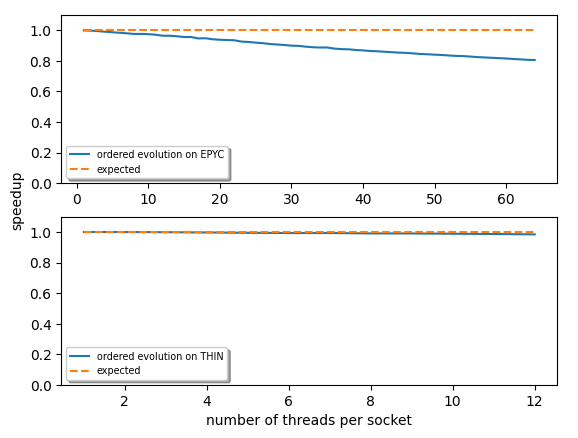

In [41]:
# displaying results for openMP scalability on EPYC and THIN nodes with ordered evolution

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["ordered"][1], label="ordered evolution on EPYC")
ax1.plot(x_epyc, epyc_data["ordered"][0], '--', label="expected")
ax1.legend(loc='lower left', shadow=True, fontsize='x-small')
ax1.set_ylim(0, 1.1)

ax2.plot(x_thin, thin_data["ordered"][1], label="ordered evolution on THIN")
ax2.plot(x_thin, thin_data["ordered"][0], '--', label="expected")
ax2.legend(loc='lower left', shadow=True, fontsize='x-small')
ax2.set_ylim(0, 1.1)

ax.set_xlabel("number of threads per socket")
ax.set_ylabel("speedup")

plt.savefig('omp_scal_ordered.png', dpi=300)

### Static

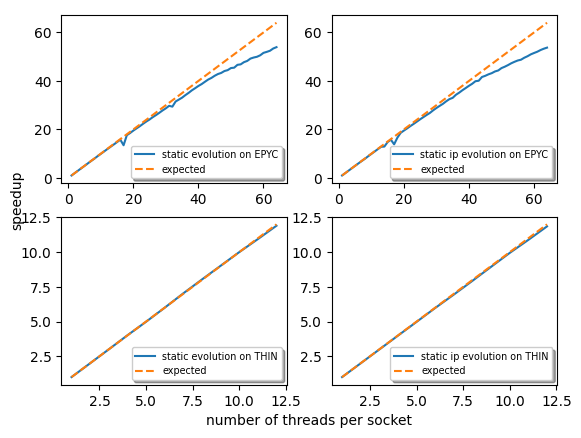

In [42]:
# displaying results for openMP scalability on EPYC and THIN nodes with static evolution

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["static"][1], label="static evolution on EPYC")
ax1.plot(x_epyc, epyc_data["static"][0], '--', label="expected")
ax1.legend(loc='lower right', shadow=True, fontsize='x-small')

ax2.plot(x_epyc, epyc_data["static_in_place"][1], label="static ip evolution on EPYC")
ax2.plot(x_epyc, epyc_data["static_in_place"][0], '--', label="expected")
ax2.legend(loc='lower right', shadow=True, fontsize='x-small')

ax3.plot(x_thin, thin_data["static"][1], label="static evolution on THIN")
ax3.plot(x_thin, thin_data["static"][0], '--', label="expected")
ax3.legend(loc='lower right', shadow=True, fontsize='x-small')

ax4.plot(x_thin, thin_data["static_in_place"][1], label="static ip evolution on THIN")
ax4.plot(x_thin, thin_data["static_in_place"][0], '--', label="expected")
ax4.legend(loc='lower right', shadow=True, fontsize='x-small')

ax.set_xlabel("number of threads per socket")
ax.set_ylabel("speedup")

plt.savefig('omp_scal_static.png', dpi=300)

## Strong MPI scalability

In [43]:
# getting data

x_epyc = np.arange(1, 5)
x_thin = np.arange(1, 5)

epyc_data = compute_speedup("EPYC", 1)
thin_data = compute_speedup("THIN", 1)

### Ordered

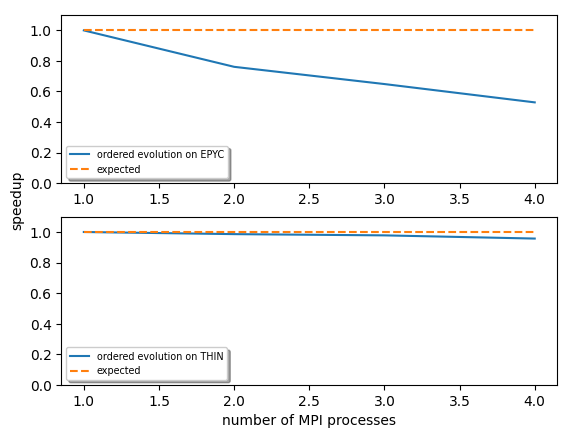

In [44]:
# displaying results for strong MPI scalability on EPYC and THIN nodes with ordered evolution

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["ordered"][1], label="ordered evolution on EPYC")
ax1.plot(x_epyc, epyc_data["ordered"][0], '--', label="expected")
ax1.legend(loc='lower left', shadow=True, fontsize='x-small')
ax1.set_ylim(0, 1.1)

ax2.plot(x_thin, thin_data["ordered"][1], label="ordered evolution on THIN")
ax2.plot(x_thin, thin_data["ordered"][0], '--', label="expected")
ax2.legend(loc='lower left', shadow=True, fontsize='x-small')
ax2.set_ylim(0, 1.1)

ax.set_xlabel("number of MPI processes")
ax.set_ylabel("speedup")

plt.savefig('strong_mpi_scal_ordered.png', dpi=300)

### Static

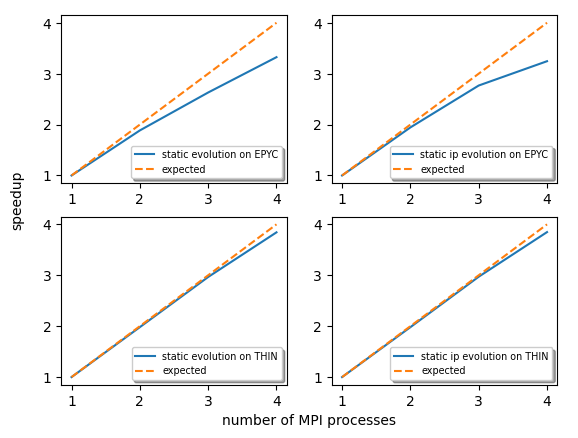

In [45]:
# displaying results for strong MPI scalability on EPYC and THIN nodes with static evolution

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["static"][1], label="static evolution on EPYC")
ax1.plot(x_epyc, epyc_data["static"][0], '--', label="expected")
ax1.legend(loc='lower right', shadow=True, fontsize='x-small')

ax2.plot(x_epyc, epyc_data["static_in_place"][1], label="static ip evolution on EPYC")
ax2.plot(x_epyc, epyc_data["static_in_place"][0], '--', label="expected")
ax2.legend(loc='lower right', shadow=True, fontsize='x-small')

ax3.plot(x_thin, thin_data["static"][1], label="static evolution on THIN")
ax3.plot(x_thin, thin_data["static"][0], '--', label="expected")
ax3.legend(loc='lower right', shadow=True, fontsize='x-small')

ax4.plot(x_thin, thin_data["static_in_place"][1], label="static ip evolution on THIN")
ax4.plot(x_thin, thin_data["static_in_place"][0], '--', label="expected")
ax4.legend(loc='lower right', shadow=True, fontsize='x-small')

ax.set_xlabel("number of MPI processes")
ax.set_ylabel("speedup")

plt.savefig('strong_mpi_scal_static.png', dpi=300)

## Weak MPI scalability

In [46]:
# getting data

x_epyc = np.arange(1, 5)
x_thin = np.arange(1, 5)

epyc_data = compute_speedup("EPYC", 2)
thin_data = compute_speedup("THIN", 2)

### Ordered

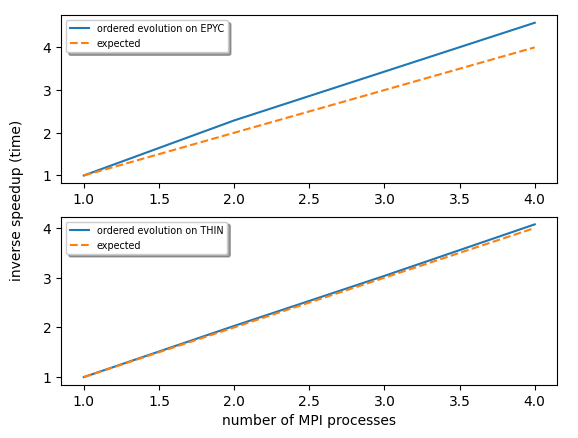

In [47]:
# displaying results for weak MPI scalability on EPYC and THIN nodes with ordered evolution (here
# it is more instructive to plot the inverse speedup)

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["ordered"][1], label="ordered evolution on EPYC")
ax1.plot(x_epyc, epyc_data["ordered"][0], '--', label="expected")
ax1.legend(loc='upper left', shadow=True, fontsize='x-small')

ax2.plot(x_thin, thin_data["ordered"][1], label="ordered evolution on THIN")
ax2.plot(x_thin, thin_data["ordered"][0], '--', label="expected")
ax2.legend(loc='upper left', shadow=True, fontsize='x-small')

ax.set_xlabel("number of MPI processes")
ax.set_ylabel("inverse speedup (time)")

plt.savefig('weak_mpi_scal_ordered.png', dpi=300)

### Static

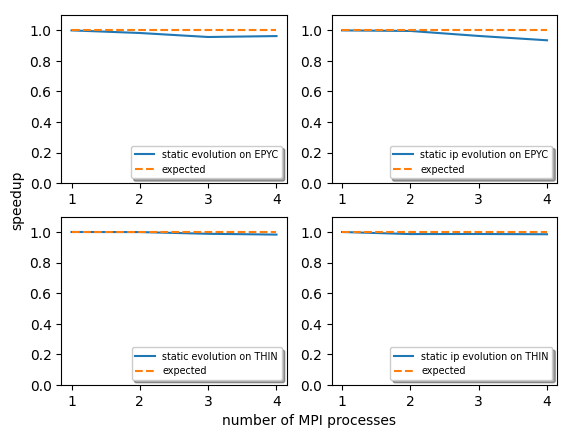

In [48]:
# displaying results for weak MPI scalability on EPYC and THIN nodes with static evolution

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(x_epyc, epyc_data["static"][1], label="static evolution on EPYC")
ax1.plot(x_epyc, epyc_data["static"][0], '--', label="expected")
ax1.legend(loc='lower right', shadow=True, fontsize='x-small')
ax1.set_ylim(0, 1.1)

ax2.plot(x_epyc, epyc_data["static_in_place"][1], label="static ip evolution on EPYC")
ax2.plot(x_epyc, epyc_data["static_in_place"][0], '--', label="expected")
ax2.legend(loc='lower right', shadow=True, fontsize='x-small')
ax2.set_ylim(0, 1.1)

ax3.plot(x_thin, thin_data["static"][1], label="static evolution on THIN")
ax3.plot(x_thin, thin_data["static"][0], '--', label="expected")
ax3.legend(loc='lower right', shadow=True, fontsize='x-small')
ax3.set_ylim(0, 1.1)

ax4.plot(x_thin, thin_data["static_in_place"][1], label="static ip evolution on THIN")
ax4.plot(x_thin, thin_data["static_in_place"][0], '--', label="expected")
ax4.legend(loc='lower right', shadow=True, fontsize='x-small')
ax4.set_ylim(0, 1.1)

ax.set_xlabel("number of MPI processes")
ax.set_ylabel("speedup")

plt.savefig('weak_mpi_scal_static.png', dpi=300)